<a href="https://colab.research.google.com/github/FJSD08/master-series-forecasting-notebook/blob/main/EnbPI_Forquilhas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install aws-fortuna==0.1.36

In [ ]:
!pip install jax==0.4.14
!pip install jaxlib==0.4.14

  Using cached jax-0.4.14-py3-none-any.whl
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires jax>=0.4.16, but you have jax 0.4.14 which is incompatible.


In [ ]:
import ml_dtypes
import numpy as np
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor

from fortuna.conformal import EnbPI
from fortuna.conformal import QuantileConformalRegressor
from fortuna.metric.regression import prediction_interval_coverage_probability


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Mestrado/DataSet_PZs_ForquilhasV.xlsx')
data

,TIMESTAMP,PZE01,PZE03,PZE04,PZE05,PZE06,PZE07,PZE08,PZE09,PZE10,PZE11,PZE12,PZE13
0,2023-01-17 11:00:00,1.342951,-0.182565,0.029329,-0.030523,-0.413892,0.028997,0.186868,4.332498,3.278466,3.582648,2.035457,4.734820
1,2023-01-17 12:00:00,1.323022,-0.173670,0.030126,-0.032635,-0.420420,0.032528,0.180509,4.326719,3.275582,3.589416,2.039707,4.735727
2,2023-01-17 13:00:00,1.327751,-0.179015,0.043033,-0.037601,-0.430876,0.033393,0.177111,4.325400,3.275379,3.588884,2.035494,4.731488
3,2023-01-17 14:00:00,1.336536,-0.173631,0.042637,-0.028208,-0.422311,0.033751,0.182295,4.332095,3.275108,3.589302,2.035837,4.733491
4,2023-01-17 15:00:00,1.340861,-0.185186,0.039688,-0.033874,-0.421856,0.029028,0.179038,4.337240,3.274470,3.592537,2.034507,4.732096
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3949,2023-07-02 13:00:00,1.650003,-0.167794,0.032550,-0.034736,-0.541352,0.030934,0.172135,4.254673,3.188140,3.658848,2.013674,4.750950
3950,2023-07-02 14:00:00,1.650445,-0.169779,0.032408,-0.032878,-0.540463,0.030565,0.171855,4.255033,3.187416,3.657538,2.013823,4.752974
3951,2023-07-02 15:00:00,1.653503,-0.172255,0.032266,-0.031019,-0.539573,0.030115,0.171576,4.255394,3.186692,3.657295,2.013971,4.754998
3952,2023-07-02 16:00:00,1.656560,-0.174731,0.032124,-0.029161,-0.538684,0.029664,0.171296,4.255754,3.185967,3.657051,2.014120,4.757022


In [ ]:
# Convertendo a coluna 'TIMESTAMP' para o formato datetime
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], format='%d/%m/%Y %H:%M')

# Definindo 'TIMESTAMP' como índice do DataFrame
data.set_index('TIMESTAMP', inplace=True)

In [ ]:
# Supondo que 'data' é um DataFrame Pandas e 'target' é a coluna que você deseja prever
X = data.drop('PZE13', axis=1)  # Substitua 'target' pelo nome real da sua variável dependente
y = data['PZE13']  # Variável dependente

In [ ]:
# Dividir os dados em treino e teste não é tão simples quanto uma divisão aleatória em dados temporais
# Walk-Forward Validation para séries temporais
n_train = int(len(X) * 0.8)
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

print(f"Treino: {len(X_train)}, Teste: {len(X_test)} ")

Treino: 3163, Teste: 791 


In [ ]:
import numpy as np

class DataFrameBootstrapper:
    def __init__(self, n_samples: int):
        self.n_samples = n_samples

    def __call__(
        self, X: np.ndarray, y: np.ndarray
    ) -> tuple[np.ndarray, list[tuple[np.ndarray, np.ndarray]]]:
        indices = np.random.choice(y.shape[0], size=(self.n_samples, y.shape[0]))
        return indices, [(X.iloc[idx], y.iloc[idx]) for idx in indices]

In [ ]:
n_bs_samples = 12
bs_indices, bs_train_data = DataFrameBootstrapper(n_samples=n_bs_samples)(
    X_train, y_train
)

In [ ]:
# returns 11 boostrap samples from the training set
bs_indices.shape

(24, 3163)

In [ ]:
bs_indices

array([[2091, 1814, 1631, ..., 3110, 3003, 2894],
       [2136,  711,  391, ...,  458, 1007, 2175],
       [2853, 1281, 2244, ...,  289,  445, 2007],
       ...,
       [1174,  115, 2511, ..., 1485,  725, 2144],
       [1314,  877,  352, ..., 2118, 2980,  151],
       [2896, 2895, 1053, ..., 2052, 3045, 2866]])

In [ ]:
X_train.shape

(3163, 11)

In [ ]:
len(bs_train_data)

24

In [ ]:
# first bootstrap sample - X
bs_train_data[0][0]

,PZE01,PZE03,PZE04,PZE05,PZE06,PZE07,PZE08,PZE09,PZE10,PZE11,PZE12
TIMESTAMP,,,,,,,,,,,
2023-04-15 13:00:00,1.691271,-0.183751,0.108790,-0.031322,-0.513641,0.030868,0.169394,4.291897,3.241410,3.713523,2.028209
2023-04-04 00:00:00,1.725006,-0.179663,0.136909,-0.034672,-0.508886,0.028938,0.173275,4.306708,3.246929,3.718403,2.028868
2023-03-27 03:00:00,1.718650,-0.187919,0.169332,-0.028269,-0.490130,0.027772,0.173806,4.327389,3.253927,3.722542,2.025823
2023-05-05 06:00:00,1.713496,-0.177564,0.037785,-0.028696,-0.507989,0.028532,0.175556,4.278060,3.225824,3.698902,2.021569
2023-02-15 16:00:00,1.362910,-0.185624,0.085588,-0.033321,-0.458479,0.024135,0.177521,4.331286,3.287952,3.697399,2.056853
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-18 20:00:00,1.648995,-0.182264,0.105152,-0.032251,-0.516889,0.029969,0.169556,4.298744,3.245166,3.713721,2.025673
2023-02-06 04:00:00,1.323942,-0.180782,0.032284,-0.030199,-0.427107,0.027428,0.180824,4.332989,3.280328,3.678054,2.037369
2023-05-28 11:00:00,1.675450,-0.180752,0.030905,-0.029523,-0.519475,0.027861,0.174669,4.276339,3.215304,3.684019,2.015692


In [ ]:
# first bootstrap sample - y
bs_train_data[0][1]

TIMESTAMP
2023-04-15 13:00:00    4.774326
2023-04-04 00:00:00    4.787457
2023-03-27 03:00:00    4.792429
2023-05-05 06:00:00    4.767375
2023-02-15 16:00:00    4.782159
                         ...   
2023-04-18 20:00:00    4.783695
2023-02-06 04:00:00    4.764562
2023-05-28 11:00:00    4.770906
2023-05-24 00:00:00    4.769758
2023-05-19 11:00:00    4.774510
Name: PZE13, Length: 3163, dtype: float64

In [ ]:
# Get a boolean series where True indicates the index is duplicated
duplicate_indices = bs_train_data[0][0].index.duplicated(keep=False)

# Print the duplicated indices
print(bs_train_data[0][0].index[duplicate_indices])

DatetimeIndex(['2023-04-15 13:00:00', '2023-04-04 00:00:00',
               '2023-05-05 06:00:00', '2023-03-08 09:00:00',
               '2023-02-21 22:00:00', '2023-04-21 18:00:00',
               '2023-02-18 08:00:00', '2023-05-22 23:00:00',
               '2023-03-19 10:00:00', '2023-03-11 15:00:00',
               ...
               '2023-05-17 02:00:00', '2023-04-10 01:00:00',
               '2023-04-12 01:00:00', '2023-03-06 17:00:00',
               '2023-03-12 19:00:00', '2023-03-31 23:00:00',
               '2023-02-06 04:00:00', '2023-05-28 11:00:00',
               '2023-05-24 00:00:00', '2023-05-19 11:00:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=2017, freq=None)


In [ ]:
bs_train_data[0][0].loc[bs_train_data[0][0].index[duplicate_indices][0]]

,PZE01,PZE03,PZE04,PZE05,PZE06,PZE07,PZE08,PZE09,PZE10,PZE11,PZE12
TIMESTAMP,,,,,,,,,,,
2023-04-15 13:00:00,1.691271,-0.183751,0.10879,-0.031322,-0.513641,0.030868,0.169394,4.291897,3.24141,3.713523,2.028209
2023-04-15 13:00:00,1.691271,-0.183751,0.10879,-0.031322,-0.513641,0.030868,0.169394,4.291897,3.24141,3.713523,2.028209


In [ ]:
'''
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

# Configurando o pipeline com apenas o RandomForestRegressor
rf_pipeline = make_pipeline(
    RandomForestRegressor(random_state=42)
).set_output(transform="pandas")
# Supondo que X_train e y_train sejam suas variáveis de treino
# rf_pipeline.fit(X_train, y_train)  # Você usaria isso para treinar o modelo
# predictions = rf_pipeline.predict(X_test)  # E isso para fazer previsões

'''

'\nfrom sklearn.pipeline import make_pipeline\nfrom sklearn.ensemble import RandomForestRegressor\n\n# Configurando o pipeline com apenas o RandomForestRegressor\nrf_pipeline = make_pipeline(\n    RandomForestRegressor(random_state=42)\n).set_output(transform="pandas")\n# Supondo que X_train e y_train sejam suas variáveis de treino\n# rf_pipeline.fit(X_train, y_train)  # Você usaria isso para treinar o modelo\n# predictions = rf_pipeline.predict(X_test)  # E isso para fazer previsões\n\n'

In [ ]:

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import HistGradientBoostingRegressor

# Configurando o pipeline com apenas o HistGradientBoostingRegressor
gbrt_pipeline = make_pipeline(
    HistGradientBoostingRegressor(random_state=42)
).set_output(transform="pandas")


In [ ]:

#GRADIENTE BOOSTING

bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    gbrt_pipeline.fit(*batch)
    bs_train_preds[i] = gbrt_pipeline.predict(X_train)  # Correção aqui
    bs_test_preds[i] = gbrt_pipeline.predict(X_test)  # Correção aqui



In [ ]:
'''
# RANDOM FOREST

bs_train_preds = np.zeros((n_bs_samples, X_train.shape[0]))
bs_test_preds = np.zeros((n_bs_samples, X_test.shape[0]))
for i, batch in enumerate(bs_train_data):
    rf_pipeline.fit(*batch)
    bs_train_preds[i] = rf_pipeline.predict(X_train)
    bs_test_preds[i] = rf_pipeline.predict(X_test)

'''

In [ ]:
predictions = gbrt_pipeline.predict(X_test)  # E isso para fazer previsõesf

In [ ]:
conformal_intervals = EnbPI().conformal_interval(
    bootstrap_indices=bs_indices,
    bootstrap_train_preds=bs_train_preds,
    bootstrap_test_preds=bs_test_preds,
    train_targets=y_train.values,
    error=0.05,
)

In [ ]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals.T, y_test.values)}."
)
print(f"Size of the conformal intervals: {np.diff(conformal_intervals)[0][0]}")

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.9140328764915466.
Size of the conformal intervals: 0.02062511444091797


In [ ]:
'''

import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_test, predictions e conformal_intervals sejam suas séries de dados
# Você precisará garantir que predictions e conformal_intervals também sejam arrays ou pandas Series
# Vamos assumir que todos esses dados já estão alinhados e formatados corretamente.

n_points = len(y_test)  # Calculando o número de pontos de dados

# Criando o gráfico
plt.figure(figsize=(12, 4))
plt.plot(y_test, label="True Test Target", color="blue")
plt.plot(predictions, label="Predictions", color="green", linestyle='--')
plt.fill_between(
    np.arange(n_points),
    conformal_intervals[:, 0],  # Limite inferior
    conformal_intervals[:, 1],  # Limite superior
    alpha=0.5,
    color="gray",
    label="Conformal Interval"
)
plt.xlabel("Data Points", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
plt.show()

'''

'\n\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Suponha que y_test, predictions e conformal_intervals sejam suas séries de dados\n# Você precisará garantir que predictions e conformal_intervals também sejam arrays ou pandas Series\n# Vamos assumir que todos esses dados já estão alinhados e formatados corretamente.\n\nn_points = len(y_test)  # Calculando o número de pontos de dados\n\n# Criando o gráfico\nplt.figure(figsize=(12, 4))\nplt.plot(y_test, label="True Test Target", color="blue")\nplt.plot(predictions, label="Predictions", color="green", linestyle=\'--\')\nplt.fill_between(\n    np.arange(n_points),\n    conformal_intervals[:, 0],  # Limite inferior\n    conformal_intervals[:, 1],  # Limite superior\n    alpha=0.5,\n    color="gray",\n    label="Conformal Interval"\n)\nplt.xlabel("Data Points", fontsize=14)\nplt.ylabel("Values", fontsize=14)\nplt.legend(fontsize=11, loc="upper right")\nplt.show()\n\n'

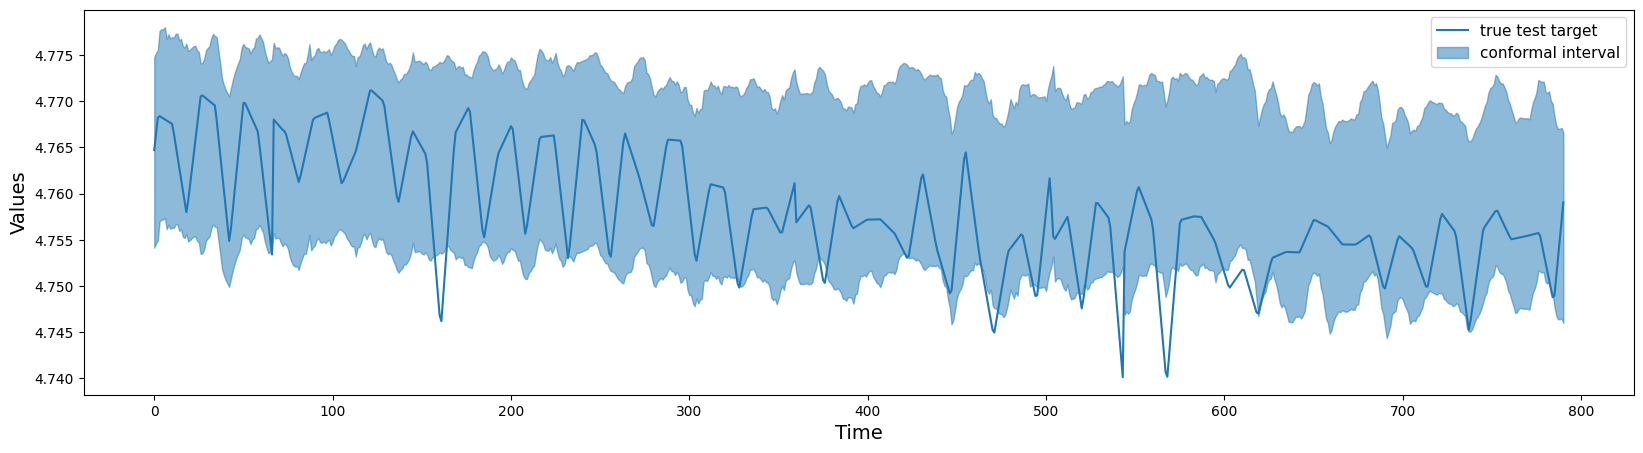

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.values, label="true test target")
plt.fill_between(
    np.arange(len(y_test)),
    conformal_intervals[:, 0],
    conformal_intervals[:, 1],
    alpha=0.5,
    color="C0",
    label="conformal interval",
)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.legend(fontsize=11, loc="upper right")
plt.show()

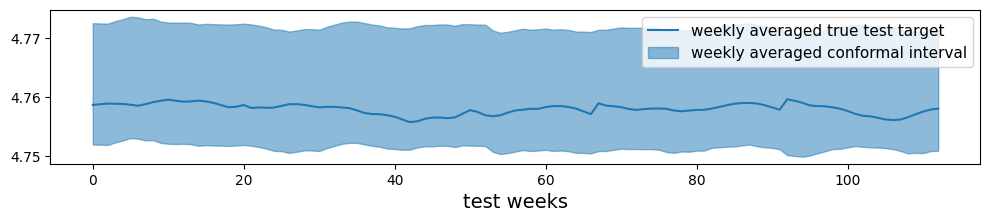

In [ ]:
def weakly_avg(x):
    s = x.shape[0] // 7
    x = x[: s * 7]
    return x.reshape(7, s, *x.shape[1:]).mean(0)


weekly_avg_test = weakly_avg(y_test.values)
n_weeks = weekly_avg_test.shape[0]

plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

In [ ]:
batch_size = 1
conformal_intervals2 = np.zeros((len(y_test), 2))
for i in range(0, len(y_test), batch_size):
    if i == 0:
        conformal_intervals2[:batch_size], train_residuals = EnbPI().conformal_interval(
            bootstrap_indices=bs_indices,
            bootstrap_train_preds=bs_train_preds,
            bootstrap_test_preds=bs_test_preds[:, :batch_size],
            train_targets=y_train.values,
            error=0.05,
            return_residuals=True,
        )
    else:
        (
            conformal_intervals2[i : i + batch_size],
            train_residuals,
        ) = EnbPI().conformal_interval_from_residuals(
            train_residuals=train_residuals,
            bootstrap_new_train_preds=bs_test_preds[:, i - batch_size : i],
            bootstrap_new_test_preds=bs_test_preds[:, i : i + batch_size],
            new_train_targets=y_test.values[i - batch_size : i],
            error=0.05,
        )

In [ ]:
print(
    "Percentage of intervals containing average bootstrap predictions: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, bs_test_preds.mean(0))}."
)
print(
    "Percentage of intervals containing true targets: "
    f"{prediction_interval_coverage_probability(*conformal_intervals2.T, y_test.values)}."
)

Percentage of intervals containing average bootstrap predictions: 1.0.
Percentage of intervals containing true targets: 0.9279393553733826.


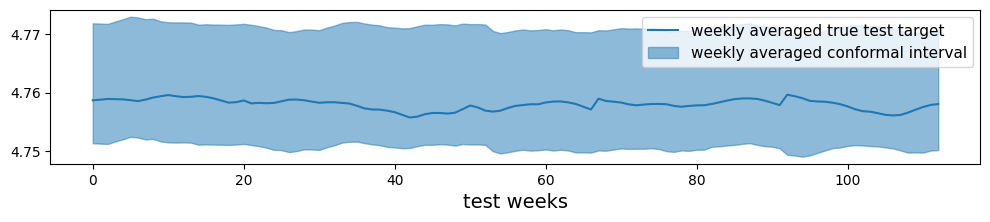

In [ ]:
plt.figure(figsize=(12, 2))
plt.plot(weakly_avg(y_test.values), label="weekly averaged true test target")
plt.fill_between(
    np.arange(n_weeks),
    *weakly_avg(conformal_intervals2).T,
    alpha=0.5,
    color="C0",
    label="weekly averaged conformal interval",
)
plt.xlabel("test weeks", fontsize=14)
plt.legend(fontsize=11, loc="upper right")

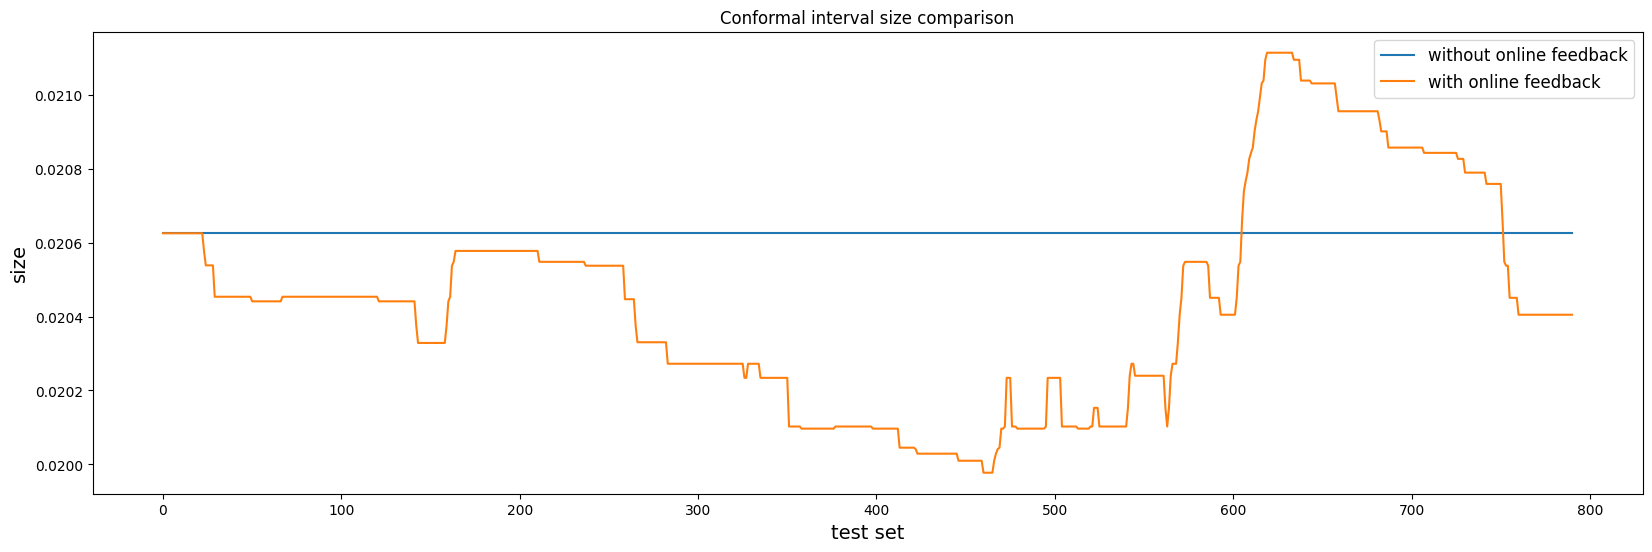

In [ ]:
# The following plot compares the size of the intervals without and with online feedback.
plt.figure(figsize=(20, 6))
plt.title("Conformal interval size comparison")
plt.plot(np.diff(conformal_intervals), label="without online feedback")
plt.plot(np.diff(conformal_intervals2), label="with online feedback")
plt.xlabel("test set", fontsize=14)
plt.ylabel("size", fontsize=14)
plt.legend(fontsize=12)